In [ ]:
import string
import re
from pickle import dump
from unicodedata import normalize
from numpy import array
 
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
 
# split a loaded document into sentences
def to_pairs(doc):
    lines = doc.strip().split('\n')
    pairs = [line.split('\t') for line in  lines]
    return pairs
 
# clean a list of lines
def clean_pairs(lines):
    cleaned = list()
    # prepare regex for char filtering
    re_print = re.compile('[^%s]' % re.escape(string.printable))
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for pair in lines:
        clean_pair = list()
        for line in pair:
            # normalize unicode characters
            line = normalize('NFD', line).encode('ascii', 'ignore')
            line = line.decode('UTF-8')
            # tokenize on white space
            line = line.split()
            # convert to lowercase
            line = [word.lower() for word in line]
            # remove punctuation from each token
            line = [word.translate(table) for word in line]
            # remove non-printable chars form each token
            line = [re_print.sub('', w) for w in line]
            # remove tokens with numbers in them
            line = [word for word in line if word.isalpha()]
            # store as string
            clean_pair.append(' '.join(line))
        cleaned.append(clean_pair)
    return array(cleaned)
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
 
# load dataset
filename = 'quech.txt'
doc = load_doc(filename)
# split into english-german pairs
pairs = to_pairs(doc)
# clean sentences
clean_pairs = clean_pairs(pairs)
# save clean pairs to file
save_clean_data(clean_pairs, 'spanish-quechua.pkl')
# spot check
for i in range(100):
    print('[%s] => [%s]' % (clean_pairs[i,0], clean_pairs[i,1]))

Saved: spanish-quechua.pkl
[dia] => [punchaw]
[mes] => [killa]
[sol] => [inti]
[ver] => [rikuy]
[ropa] => [pacha]
[luna] => [killa]
[nube] => [puyu]
[leer] => [nawinchay]
[leer] => [likay]
[tarde] => [suka]
[venir] => [hamuy]
[mirar] => [qaway]
[noche] => [tuta]
[zorro] => [atuq]
[lunes] => [killachay punchaw]
[contar] => [willay]
[avisar] => [willay]
[hablar] => [rimay]
[contar] => [yupay]
[martes] => [antichay punchaw]
[lluvia] => [para]
[viento] => [wayra]
[tiempo] => [pacha]
[tierra] => [pacha]
[jueves] => [illapachay punchaw]
[sabado] => [kuychichay punchaw]
[neblina] => [puyu]
[domingo] => [intichay punchaw]
[viernes] => [chaskachay punchaw]
[profesor] => [yachachiq]
[estrella] => [chaska]
[escribir] => [qillqay]
[trabajar] => [llamkay]
[conversar] => [parlay]
[miercoles] => [qurlluychay punchaw]
[profesora] => [yachachiq]
[ejercicios] => [ruwanapaq]
[abecedario] => [achahala]
[bienvenidos] => [allin hamuy]
[estudiantes] => [yachaqkuna]
[yo soy saywa] => [nuqa saywam kani]
[yo so

In [ ]:
import pickle as pk
from pickle import dump
from numpy.random import rand
from numpy.random import shuffle
 
# load a clean dataset
def load_clean_sentences(filename):
    return pk.load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
    dump(sentences, open(filename, 'wb'))
    print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('spanish-quechua.pkl')
 
# reduce dataset size
n_sentences = 1100
dataset = raw_dataset[:n_sentences, :]
# random shuffle
shuffle(dataset)
# split into train/test
train, test = dataset[:990], dataset[990:]
# save
save_clean_data(dataset, 'spanish-quechua-both.pkl')
save_clean_data(train, 'spanish-quechua-train.pkl')
save_clean_data(test, 'spanish-quechua-test.pkl')

Saved: spanish-quechua-both.pkl
Saved: spanish-quechua-train.pkl
Saved: spanish-quechua-test.pkl


In [ ]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
 
# load a clean dataset
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
# max sentence length
def max_length(lines):
    return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    X = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
 
# load datasets
dataset = load_clean_sentences('spanish-quechua-both.pkl')
train = load_clean_sentences('spanish-quechua-train.pkl')
test = load_clean_sentences('spanish-quechua-test.pkl')
 
# prepare spanish tokenizer
spa_tokenizer = create_tokenizer(dataset[:, 0])
spa_vocab_size = len(spa_tokenizer.word_index) + 1
spa_length = max_length(dataset[:, 0])
print('Spanish Vocabulary Size: %d' % spa_vocab_size)
print('Spanish Max Length: %d' % (spa_length))
# prepare quechua tokenizer
que_tokenizer = create_tokenizer(dataset[:, 1])
que_vocab_size = len(que_tokenizer.word_index) + 1
que_length = max_length(dataset[:, 1])
print('Quechua Vocabulary Size: %d' % que_vocab_size)
print('Quechua Max Length: %d' % (que_length))
 
# prepare training data
trainX = encode_sequences(que_tokenizer, que_length, train[:, 1])
trainY = encode_sequences(spa_tokenizer, spa_length, train[:, 0])
trainY = encode_output(trainY, spa_vocab_size)

# prepare validation data
testX = encode_sequences(que_tokenizer, que_length, test[:, 1])
testY = encode_sequences(spa_tokenizer, spa_length, test[:, 0])
testY = encode_output(testY, spa_vocab_size)
 
# define model
model = define_model(que_vocab_size, spa_vocab_size, que_length, spa_length, 1000)
model.compile(optimizer='adam', loss='categorical_crossentropy')
# summarize defined model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)
# save the model
model.save('s2s_Token.h5')
# fit model
# filename = 'model.h5'
# checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
hist = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), verbose=2)
# history = model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY))

Spanish Vocabulary Size: 1522
Spanish Max Length: 19
Quechua Vocabulary Size: 1645
Quechua Max Length: 10
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 1000)          1645000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 19, 1000)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 19, 1000)          8004000   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 1522)          1523522   
Total params: 19,176,522
Trainable params: 19,176,522
Non-trainable params: 0
_________________________________________________________________
No

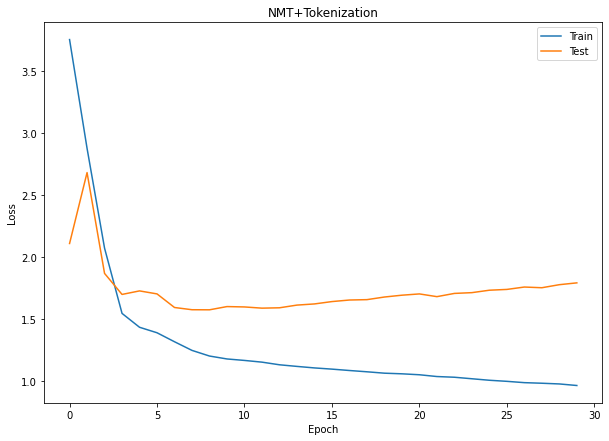

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Test')


plt.title('NMT+Tokenization')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend()

In [ ]:
from pickle import load
from numpy import array
from numpy import argmax
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
 
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
 
# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)
 
# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
	actual, predicted = list(), list()
	for i, source in enumerate(sources):
		# translate encoded source text
		source = source.reshape((1, source.shape[0]))
		translation = predict_sequence(model, spa_tokenizer, source)
		raw_target, raw_src = raw_dataset[i]
		if i < 10:
			print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
		actual.append([raw_target.split()])
		predicted.append(translation.split())
	# calculate BLEU score
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
# load datasets
dataset = load_clean_sentences('spanish-quechua-both.pkl')
train = load_clean_sentences('spanish-quechua-train.pkl')
test = load_clean_sentences('spanish-quechua-test.pkl')
# prepare spanish tokenizer
spa_tokenizer = create_tokenizer(dataset[:, 0])
spa_vocab_size = len(spa_tokenizer.word_index) + 1
spa_length = max_length(dataset[:, 0])
# prepare quechua tokenizer
que_tokenizer = create_tokenizer(dataset[:, 1])
que_vocab_size = len(que_tokenizer.word_index) + 1
que_length = max_length(dataset[:, 1])
# prepare data
trainX = encode_sequences(que_tokenizer, que_length, train[:, 1])
testX = encode_sequences(que_tokenizer, que_length, test[:, 1])

# load model
model = load_model('s2s_Token.h5')
# test on some training sequences
print('train')
evaluate_model(model, spa_tokenizer, trainX, train)
# test on some test sequences
print('test')
#evaluate_model(model, spa_tokenizer, testX, test)
evaluate_model(model, que_tokenizer, testX, test)

train
src=[apu rasu willkaqa apu sara sarawan rimanakunmi], target=[el dios tutelar razuhuillca y el sara sara conversan entre ellos], predicted=[hermosas hermosas ovillo ovillo tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar tumbar]
src=[akaqa millaytam asnan], target=[el excremento huele horrible], predicted=[sabado sabado sabado sabado haz haz haz haz haz haz haz ningun ningun ningun ningun ningun ningun ningun ningun]
src=[chuspi], target=[mosca], predicted=[huecos sara sara sara sara sara sara sara sara sara sara sara sara sara sara sara sara sara sara]
src=[kallchay], target=[cosechar kiwicha], predicted=[reprender reprender reprender reprender reprender reprender estornudar estornudar estornudar estornudar estornudar estornudar estornudar estornudar estornudar estornudar estornudar estornudar estornudar]
src=[kiswartana yantarqusun], target=[hagamos lena de quishuar], predicted=[congregarse congregarse congregarse fue fue fue fue

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU-1: 0.000213
BLEU-2: 0.014602
BLEU-3: 0.079187
BLEU-4: 0.120841
test
src=[churuna], target=[herramienta de labranza], predicted=[hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas hojitas]
src=[akaklluhinam qaqata tuquchkanki], target=[estas cavando en la roca como el pito], predicted=[huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay huacatay]
src=[aranwaywanqa asinchikmi], target=[nos reimos con las canciones jocosas], predicted=[izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo izquierdo]
src=[hamuy], target=[venir], predicted=[barro barro barro barro barro barro barro barro barro barro barro barro barro barro barro barro telarana telarana telarana]
